In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.utils import instantiate
from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.8.1+cu102
cuda:0


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
with initialize(config_path='./scripts/'):
    cfg = compose("m2")

print('config: ')
print(cfg)

config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [686.0, 1123.0], 'n_batches': 10, 'batch_size': 20, 'generate_device': 'cuda:3', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 2, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'psf_params_file': '../../../data/sdss/2583/2/136/psField-002583-2-0136.fits', 'sdss_bands': [2, 3]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 8, 'max_detections': 2, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185, 'one_hot_tile': True}, 'prior': {'_target_': 'bliss.mod

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [6]:
cfg.models.decoder.psf_params_file = './../../data/sdss/2583/2/136/psField-002583-2-0136.fits'

In [7]:
model_filename = './fits/starnet-m2-20220831'

dataset = instantiate(cfg.training.dataset)

sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [8]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [9]:
# pl.seed_everything(345435)

# from bliss.datasets import simulated 
# cfg.dataset.kwargs.update({'batch_size': 1})
# dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

# batch =  dataset.get_batch()
# print(sleep_net.get_loss(batch)[0])

# print((batch['images']**2).mean())

# Load m2 data

In [10]:
run = 2583
camcol = 2
field = 136

sdss_frame, hubble_catalog, sdss_background, sdss_data, wcs = \
    m2_data.load_m2_data()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [11]:
# filter by bright stars 
fmin = 1000.
hubble_catalog = plotting.filter_catalog(hubble_catalog,
                                         hubble_catalog['fluxes'][:, 0] > fmin)

In [12]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [13]:
nelec_per_nmgy

856.09845

### We focus on this chunk

In [14]:
x0 = 630
x1 = 310
chunk_slen = 100

border_padding = sleep_net.image_encoder.border_padding

In [15]:
sdss_test_image = plotting.crop_image(sdss_frame, 
                                      x0 - border_padding, 
                                      x1 - border_padding,
                                      chunk_slen + 2 * border_padding,
                                      chunk_slen + 2 * border_padding)

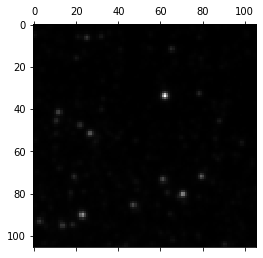

In [16]:
plt.matshow(sdss_test_image[0], 
            cmap = plt.cm.gray)

# Get starnet map estimates

In [17]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

In [18]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [19]:
sleep_net.to(device);

In [20]:
map_estimate = get_map_estimate(sleep_net.image_encoder, 
                                sdss_test_image.unsqueeze(0).to(device),
                                dataset.background.view(1, 2, 1, 1).to(device), 
                                slen = chunk_slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * chunk_slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
# assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [21]:
print(map_estimate['n_sources'])

tensor(1319)


(array([389., 430., 261., 141.,  62.,  12.,   9.,  10.,   3.,   2.]),
 array([3.0080705, 3.2976387, 3.587207 , 3.8767753, 4.1663437, 4.4559116,
        4.74548  , 5.0350485, 5.324617 , 5.614185 , 5.9037533],
       dtype=float32),
 <BarContainer object of 10 artists>)

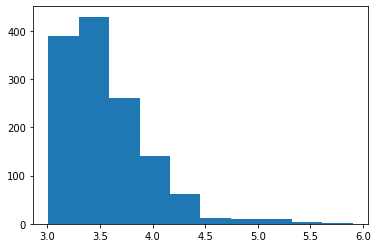

In [22]:
plt.hist(np.log10(map_estimate['fluxes'][:, 0].cpu().numpy()))

# Example subimages

# Performance metrics

In [23]:
# the PCAT catalog has a 0.5 pixel border around the edges 

# to reproduce old PCAT results, set 
# pad = 5.5
# _chunk_slen = chunk_slen - 10

pad = 0.5
_chunk_slen = chunk_slen - 2 * pad

In [24]:
# get hubble ground truth on this chunk
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0 + pad, 
                                                      x1 + pad,
                                                      _chunk_slen,
                                                      _chunk_slen)

hubble_test_mags = utils.convert_nmgy_to_mag(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)

In [25]:
def get_summary_statistics(est_catalog): 
        
    est_catalog = plotting.filter_catalog_by_locs(deepcopy(est_catalog),
                                                  x0 + pad, 
                                                  x1 + pad,
                                                  _chunk_slen,
                                                  _chunk_slen)
    est_locs = est_catalog['locs']
    est_fluxes = est_catalog['fluxes'][:, 0:1]
    
    est_mags = utils.convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)

    # get tpr and ppv as function of magnitude
    tpr_vec = starnet_metrics.get_tpr_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    ppv_vec = starnet_metrics.get_ppv_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = starnet_metrics.get_tpr_ppv(hubble_test_catalog['locs'],
                                           hubble_test_mags,
                                           est_locs,
                                           est_mags, 
                                           slack = 0.5)
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec


In [26]:
mag_bins = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

### Get results for StarNet

In [27]:
tpr, ppv, f1, starnet_tpr_vec, starnet_ppv_vec = \
    get_summary_statistics(map_estimate)

print('StarNet tpr', tpr)
print('StarNet ppv', ppv)
print('StarNet f1', f1)

StarNet tpr tensor(0.5189)
StarNet ppv tensor(0.4631)
StarNet f1 tensor(0.4894)


In [33]:
hubble_test_catalog['locs'].shape

torch.Size([1114, 2])

In [34]:
map_estimate['locs'].shape

torch.Size([1248, 2])

# Check out uncertainties 

In [28]:
def sample_encoder(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_samples = image_encoder.sample(var_params, 5000)

    return tile_samples

In [29]:
tile_samples = sample_encoder(sleep_net.image_encoder, 
                              sdss_test_image.unsqueeze(0).to(device),
                              dataset.background.view(1, 2, 1, 1).to(device), 
                              slen = chunk_slen)

In [30]:
starnet_nsources = tile_samples['n_sources'].sum(-1).sum(-1).sum(-1).detach().cpu().numpy()

In [31]:
np.quantile(starnet_nsources, q = [0.05, 0.95])

array([1379., 1446.])

In [32]:
starnet_nsources.mean()

1412.1078

In [61]:
# np.savez('../../data/true_hubble_m2', 
#          sdss_image = sdss_image.cpu(), 
#          true_locs = hubble_locs.cpu(), 
#          true_fluxes = hubble_fluxes.cpu(), 
#          nelec_per_nmgy = nelec_per_nmgy)